In [1]:
# this is jut to view the wide window in jupyter
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
# load the libraries needed
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap

## Define functions for plotting

In [3]:
def extract_region(df, chromosome, down_region, up_region, function):
    region_df = df[(df['end'] >= down_region) & (df['start'] <= up_region) & 
                   (df['seqname'].str.contains(chromosome))]
    header = region_df[['seqname','end']]
    values = region_df.iloc[:, 3:] # take only columns after "end" column
    values_func = function(values).replace(-np.inf, 0)
    return pd.concat([header, values_func], axis=1)
# consider split the above function in two and put the scaled function as below
def scale_data(df,function):
    header = df[['seqname','end']]
    values = df.iloc[:, 3:] # take only columns after "end" column
    values_func = function(values).replace(-np.inf, 0)
    return pd.concat([header, values_func], axis=1)

def transpose_df(df):    
    df_t = df.set_index(['seqname', 'end']).T
    return df_t

def plot_culstermap_col(df, fig_size=(25,300)):
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    cluster = sns.clustermap(df,
                            cbar=True,
                            vmin=0,
                            col_cluster=False,
                            # row_cluster = False, # avoid cluster rows
                            figsize=fig_size,
                            cbar_pos=(-0.01, .3, .005, .4),
                            dendrogram_ratio=(.1, .3)
#                             dendrogram_ratio=(.0001, .005)
                            )
    plt.setp(cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=15)
    plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), fontsize=15)
    return cluster

def drop_columns_rex(df, string):
    droped_df = df.set_index(['seqname', 'start', 'end']).drop(df.filter(regex=string).columns, axis=1)
    return droped_df.reset_index()

def drop_columns_list(df,sample_list):
    droped_df = df.set_index(['seqname', 'start', 'end']).drop(my_list, axis=1)
    return droped_df.reset_index()

def select_genotypes(df, sample_list):
    filter_df = df.set_index(['seqname', 'start', 'end']).filter(items=sample_list, axis=1)
    return filter_df.reset_index()

def chr_length(df, chromosome):
    len_df = pd.read_csv(df, delimiter='\t', header=None)
    return len_df[len_df[0].str.contains(f'{chromosome}')][1].values[0]

In [4]:
data_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/0_IBSpy_data'
chr_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/00_genome_sizes/'

## Define arguments
- Here you can define arguments to plot. In the example below, I'm usig the file that has 50,000 bp windows (we have other files with other windows sizes).
- the "function" is a data transformation to the sqrt to get better vizualization.
- chromosome to filter. This because these files contain all the cromosomes
- and then the region to plot (down_region, up_region)

In [5]:
# Define arguments chinese
window = 50000
function = np.sqrt
reference = 'chinese'

In [6]:
# # this is juts to list the files in my current directory
# import os
# files = os.listdir('./01_data/')
# files

## Read the file
#### NOTE: this file has all the "query" samples merged in a single file by reference

In [7]:
in_file = pd.read_csv(f'{data_path}/{reference}_combined_queries_{window}w.tsv.gz', delimiter='\t')
in_file

,seqname,start,end,arina-10x_nuq,arina-pg,cadenza-10.4x_nuq,cadenza-15x_nuq,chinese-10x_nuq,chinese-pg,claire-10x_nuq,...,WATDE1040,Aztec,WATDE0926,WATDE0168,WATDE0333,Tschermaks,WATDE0209,Drake,WATDE0015,WATDE0471
0,chr1A,1,50000,403,533,30,24,1,0,62,...,20,430,435,27,64,446,24,57,31,458
1,chr1A,50001,100000,447,508,31,19,1,0,31,...,60,468,450,23,25,467,27,23,25,474
2,chr1A,100001,150000,514,564,44,26,1,0,109,...,34,542,532,37,117,554,38,112,39,547
3,chr1A,150001,200000,484,553,42,32,0,0,37,...,31,522,507,31,41,523,29,39,35,511
4,chr1A,200001,250000,548,592,27,16,1,0,55,...,24,565,549,29,59,554,27,51,34,551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290952,chrUn,480750001,480800000,59,59,86,82,3,0,70,...,62,76,65,77,84,75,64,86,48,71
290953,chrUn,480800001,480850000,62,59,69,68,1,0,46,...,63,44,63,64,62,69,64,81,59,58
290954,chrUn,480850001,480900000,59,61,83,76,1,0,52,...,49,61,60,87,78,50,73,74,59,69
290955,chrUn,480900001,480950000,96,104,82,86,1,0,73,...,53,60,72,94,98,91,94,84,59,92


## Filter samples
- This filter can be ommited of you want to keep all the samples. In the example below I'm filtering the Aegilops tauschii accesions (prefix 'BW_')

In [8]:
droped_file = drop_columns_rex(in_file,'BW_')
# droped_file = in_file
droped_file

,seqname,start,end,arina-10x_nuq,arina-pg,cadenza-10.4x_nuq,cadenza-15x_nuq,chinese-10x_nuq,chinese-pg,claire-10x_nuq,...,WATDE1040,Aztec,WATDE0926,WATDE0168,WATDE0333,Tschermaks,WATDE0209,Drake,WATDE0015,WATDE0471
0,chr1A,1,50000,403,533,30,24,1,0,62,...,20,430,435,27,64,446,24,57,31,458
1,chr1A,50001,100000,447,508,31,19,1,0,31,...,60,468,450,23,25,467,27,23,25,474
2,chr1A,100001,150000,514,564,44,26,1,0,109,...,34,542,532,37,117,554,38,112,39,547
3,chr1A,150001,200000,484,553,42,32,0,0,37,...,31,522,507,31,41,523,29,39,35,511
4,chr1A,200001,250000,548,592,27,16,1,0,55,...,24,565,549,29,59,554,27,51,34,551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290952,chrUn,480750001,480800000,59,59,86,82,3,0,70,...,62,76,65,77,84,75,64,86,48,71
290953,chrUn,480800001,480850000,62,59,69,68,1,0,46,...,63,44,63,64,62,69,64,81,59,58
290954,chrUn,480850001,480900000,59,61,83,76,1,0,52,...,49,61,60,87,78,50,73,74,59,69
290955,chrUn,480900001,480950000,96,104,82,86,1,0,73,...,53,60,72,94,98,91,94,84,59,92


## Remove function argument to make it binary

In [9]:
chromosome='chr2B'
down_region=683034442 - 1000000
up_region=687635975 + 1000000
region = extract_region(droped_file, chromosome, down_region, up_region, function)
region

,seqname,end,arina-10x_nuq,arina-pg,cadenza-10.4x_nuq,cadenza-15x_nuq,chinese-10x_nuq,chinese-pg,claire-10x_nuq,dicoccoides-10x_nuq,...,WATDE1040,Aztec,WATDE0926,WATDE0168,WATDE0333,Tschermaks,WATDE0209,Drake,WATDE0015,WATDE0471
64847,chr2B,682050000,11.874342,11.874342,5.567764,4.242641,1.414214,0.0,12.165525,14.866069,...,10.099505,11.958261,3.316625,5.000000,4.690416,4.582576,12.124356,11.958261,5.477226,6.164414
64848,chr2B,682100000,10.535654,10.488088,5.099020,4.000000,0.000000,0.0,10.440307,16.062378,...,10.723805,10.630146,3.316625,4.472136,4.000000,3.741657,10.770330,10.488088,4.123106,4.000000
64849,chr2B,682150000,11.224972,11.000000,5.196152,3.741657,0.000000,0.0,11.000000,16.431677,...,11.180340,11.269428,3.000000,4.242641,4.898979,4.358899,11.224972,11.000000,4.000000,3.605551
64850,chr2B,682200000,9.949874,10.148892,14.798649,14.142136,1.000000,0.0,9.848858,14.866069,...,10.198039,10.344080,14.142136,5.567764,5.744563,9.433981,10.148892,10.000000,14.282857,9.327379
64851,chr2B,682250000,15.394804,15.231546,21.095023,20.736441,0.000000,0.0,15.362291,19.874607,...,15.556349,15.491933,20.297783,14.247807,5.744563,15.264338,15.874508,15.491933,20.297783,15.905974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64975,chr2B,688450000,3.872983,3.872983,21.447611,21.213203,1.414214,0.0,4.000000,15.748016,...,3.316625,4.123106,21.377558,13.266499,17.291616,12.727922,4.472136,3.872983,21.656408,12.369317
64976,chr2B,688500000,3.741657,3.605551,18.894444,18.841444,1.000000,0.0,3.741657,17.663522,...,4.472136,4.582576,19.026298,15.524175,14.456832,15.874508,4.472136,4.123106,19.078784,15.427249
64977,chr2B,688550000,3.741657,3.872983,17.691806,17.606817,1.732051,0.0,3.605551,17.521415,...,4.358899,4.000000,17.549929,17.691806,11.661904,17.635192,5.567764,4.000000,17.521415,17.635192
64978,chr2B,688600000,5.196152,5.000000,24.207437,24.166092,2.449490,0.0,5.196152,24.839485,...,4.582576,5.477226,24.062419,24.738634,16.217275,24.596748,5.744563,5.567764,24.596748,24.637370


## Extract the region we want to plot. In this case the whole chromosome
- With this filter you can plot any region you want, just put chromosome & the coordenates (down_region, up_region in the example below)
- The function parameter transform the original data to its sqrt (this is jut to have a better vuzualization)

In [10]:
# chromosome='chr2B'
# chr_len = chr_path+f'chr_sizes_{reference}.genome.txt'
# down_region = 0
# up_region = chr_length(chr_len, chromosome)
# up_region = 150000000

region = extract_region(droped_file, chromosome, down_region, up_region, function)
region

,seqname,end,arina-10x_nuq,arina-pg,cadenza-10.4x_nuq,cadenza-15x_nuq,chinese-10x_nuq,chinese-pg,claire-10x_nuq,dicoccoides-10x_nuq,...,WATDE1040,Aztec,WATDE0926,WATDE0168,WATDE0333,Tschermaks,WATDE0209,Drake,WATDE0015,WATDE0471
64847,chr2B,682050000,11.874342,11.874342,5.567764,4.242641,1.414214,0.0,12.165525,14.866069,...,10.099505,11.958261,3.316625,5.000000,4.690416,4.582576,12.124356,11.958261,5.477226,6.164414
64848,chr2B,682100000,10.535654,10.488088,5.099020,4.000000,0.000000,0.0,10.440307,16.062378,...,10.723805,10.630146,3.316625,4.472136,4.000000,3.741657,10.770330,10.488088,4.123106,4.000000
64849,chr2B,682150000,11.224972,11.000000,5.196152,3.741657,0.000000,0.0,11.000000,16.431677,...,11.180340,11.269428,3.000000,4.242641,4.898979,4.358899,11.224972,11.000000,4.000000,3.605551
64850,chr2B,682200000,9.949874,10.148892,14.798649,14.142136,1.000000,0.0,9.848858,14.866069,...,10.198039,10.344080,14.142136,5.567764,5.744563,9.433981,10.148892,10.000000,14.282857,9.327379
64851,chr2B,682250000,15.394804,15.231546,21.095023,20.736441,0.000000,0.0,15.362291,19.874607,...,15.556349,15.491933,20.297783,14.247807,5.744563,15.264338,15.874508,15.491933,20.297783,15.905974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64975,chr2B,688450000,3.872983,3.872983,21.447611,21.213203,1.414214,0.0,4.000000,15.748016,...,3.316625,4.123106,21.377558,13.266499,17.291616,12.727922,4.472136,3.872983,21.656408,12.369317
64976,chr2B,688500000,3.741657,3.605551,18.894444,18.841444,1.000000,0.0,3.741657,17.663522,...,4.472136,4.582576,19.026298,15.524175,14.456832,15.874508,4.472136,4.123106,19.078784,15.427249
64977,chr2B,688550000,3.741657,3.872983,17.691806,17.606817,1.732051,0.0,3.605551,17.521415,...,4.358899,4.000000,17.549929,17.691806,11.661904,17.635192,5.567764,4.000000,17.521415,17.635192
64978,chr2B,688600000,5.196152,5.000000,24.207437,24.166092,2.449490,0.0,5.196152,24.839485,...,4.582576,5.477226,24.062419,24.738634,16.217275,24.596748,5.744563,5.567764,24.596748,24.637370


## Transpose the data to use samples as a rows (Y, axis) and chromosome positions as X axis
- This is jut to plot the genotypes in the Y axis, and the chromosome coordentaes in the X axis

In [11]:
# %%time
region_t = transpose_df(region)
region_t

seqname                chr2B                                              \
end                682050000  682100000  682150000  682200000  682250000   
arina-10x_nuq      11.874342  10.535654  11.224972   9.949874  15.394804   
arina-pg           11.874342  10.488088  11.000000  10.148892  15.231546   
cadenza-10.4x_nuq   5.567764   5.099020   5.196152  14.798649  21.095023   
cadenza-15x_nuq     4.242641   4.000000   3.741657  14.142136  20.736441   
chinese-10x_nuq     1.414214   0.000000   0.000000   1.000000   0.000000   
...                      ...        ...        ...        ...        ...   
Tschermaks          4.582576   3.741657   4.358899   9.433981  15.264338   
WATDE0209          12.124356  10.770330  11.224972  10.148892  15.874508   
Drake              11.958261  10.488088  11.000000  10.000000  15.491933   
WATDE0015           5.477226   4.123106   4.000000  14.282857  20.297783   
WATDE0471           6.164414   4.000000   3.605551   9.327379  15.905974   

seqname                                                                   ...  \
end                682300000  682350000  682400000  682450000  682500000  ...   
arina-10x_nuq      11.313708  12.767145  12.569805  13.379088  14.798649  ...   
arina-pg           11.357817  12.529964  12.206556  13.266499  14.933185  ...   
cadenza-10.4x_nuq  18.193405  21.142375  19.026298  18.248288  19.313208  ...   
cadenza-15x_nuq    17.916473  20.904545  18.330303  17.832555  19.235384  ...   
chinese-10x_nuq     2.000000   0.000000   1.000000   1.000000   2.449490  ...   
...                      ...        ...        ...        ...        ...  ...   
Tschermaks         11.575837  12.369317  12.369317  13.114877  15.231546  ...   
WATDE0209          11.618950  12.609520  12.727922  13.379088  15.000000  ...   
Drake              11.661904  12.609520  12.449900  13.076697  14.730920  ...   
WATDE0015          14.000000  18.275667  17.146428  17.972201  18.601075  ...   
WATDE0471          12.369317  12.806248  12.328828  13.304135  15.394804  ...   

seqname                                                                   \
end                688200000  688250000  688300000  688350000  688400000   
arina-10x_nuq       5.656854   5.099020   5.477226   5.656854   3.316625   
arina-pg            5.744563   4.898979   5.196152   5.744563   3.316625   
cadenza-10.4x_nuq  22.715633  21.447611  20.880613  24.269322  20.445048   
cadenza-15x_nuq    22.405357  20.976177  20.591260  24.186773  20.346990   
chinese-10x_nuq     0.000000   0.000000   0.000000   1.414214   1.000000   
...                      ...        ...        ...        ...        ...   
Tschermaks         22.293497  21.283797  15.000000  16.733201  13.674794   
WATDE0209           5.477226   5.744563   5.830952   6.244998   4.472136   
Drake               5.830952   6.000000   4.795832   5.830952   4.000000   
WATDE0015          22.649503  21.563859  20.880613  24.535688  20.420578   
WATDE0471          22.516660  21.517435  15.231546  17.146428  13.564660   

seqname                                                                   
end                688450000  688500000  688550000  688600000  688650000  
arina-10x_nuq       3.872983   3.741657   3.741657   5.196152   5.385165  
arina-pg            3.872983   3.605551   3.872983   5.000000   5.385165  
cadenza-10.4x_nuq  21.447611  18.894444  17.691806  24.207437  20.074860  
cadenza-15x_nuq    21.213203  18.841444  17.606817  24.166092  20.074860  
chinese-10x_nuq     1.414214   1.000000   1.732051   2.449490   0.000000  
...                      ...        ...        ...        ...        ...  
Tschermaks         12.727922  15.874508  17.635192  24.596748  19.899749  
WATDE0209           4.472136   4.472136   5.567764   5.744563   5.830952  
Drake               3.872983   4.123106   4.000000   5.567764   5.916080  
WATDE0015          21.656408  19.078784  17.521415  24.596748  20.000000  
WATDE0471          12.369317  15.427249  17.635192  24.637370  20.19

## Create the clustermap
- depending of the number of samples you want to include, you can change the fig_size parameter to have better vusualization.
- WARNING: if you include all the samples and the whole chromosome this may take too much memory, depending of your computer power.

In [12]:
# fig_size=(35,300)
# plot_culstermap_col(region_t, fig_size).fig.suptitle(f'reference: {reference}_{chromosome}', fontsize=20, weight="bold", x=0.5, y=0.997) # x and y are the position of text title
# plt.savefig(f'{chromosome}_{reference}_clustermap_all_samples.pdf', dpi=70, bbox_inches='tight')

### Include few samples
- Now, if you only want to plot a few samples, just create a list of the genotypes you want, and use the function "include_columns_list"

In [20]:
# hap_path='/Users/quirozc/Documents/PhD_2020/16_watseq/22_paul/06_hap_names/'
my_list = pd.read_csv('yr7_genotypes.tsv')['genotype'].tolist()
filtered_file = select_genotypes(in_file, my_list)
filtered_file

,seqname,start,end,Thatcher,Camp_Remy,Talent,Spark,Cordiale,Grafton,festival,...,robigus2,weebil2,wasp,Hobbit,Galahad,WATDE0052,WATDE0050,WATDE0067,WATDE0033,Wyalkatatchen
0,chr1A,1,50000,46,428,22,61,34,21,427,...,51,419,52,423,53,441,33,33,22,15
1,chr1A,50001,100000,22,440,17,30,25,19,462,...,23,462,30,449,25,470,20,27,26,20
2,chr1A,100001,150000,109,518,33,113,50,35,546,...,42,503,113,531,109,546,42,46,43,26
3,chr1A,150001,200000,31,515,29,39,52,29,523,...,102,477,36,506,39,523,48,49,45,14
4,chr1A,200001,250000,46,559,27,57,37,24,533,...,45,525,53,546,49,555,53,53,34,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290952,chrUn,480750001,480800000,94,80,72,64,63,75,84,...,64,66,70,96,78,80,82,91,54,81
290953,chrUn,480800001,480850000,67,56,54,55,59,59,60,...,59,59,55,63,49,58,59,71,29,51
290954,chrUn,480850001,480900000,66,64,64,74,72,73,70,...,56,76,69,60,73,54,76,45,26,58
290955,chrUn,480900001,480950000,69,68,90,77,84,96,97,...,75,68,72,83,71,110,77,68,77,65


## Clustermap some samples
- you can define new paramters here, and change the region size & figure size if you want. In the example below I'm adding 10Mbp reegion downstream and upstream of the chr1B region

Text(0.5, 1, 'reference: chinese_chr2B')

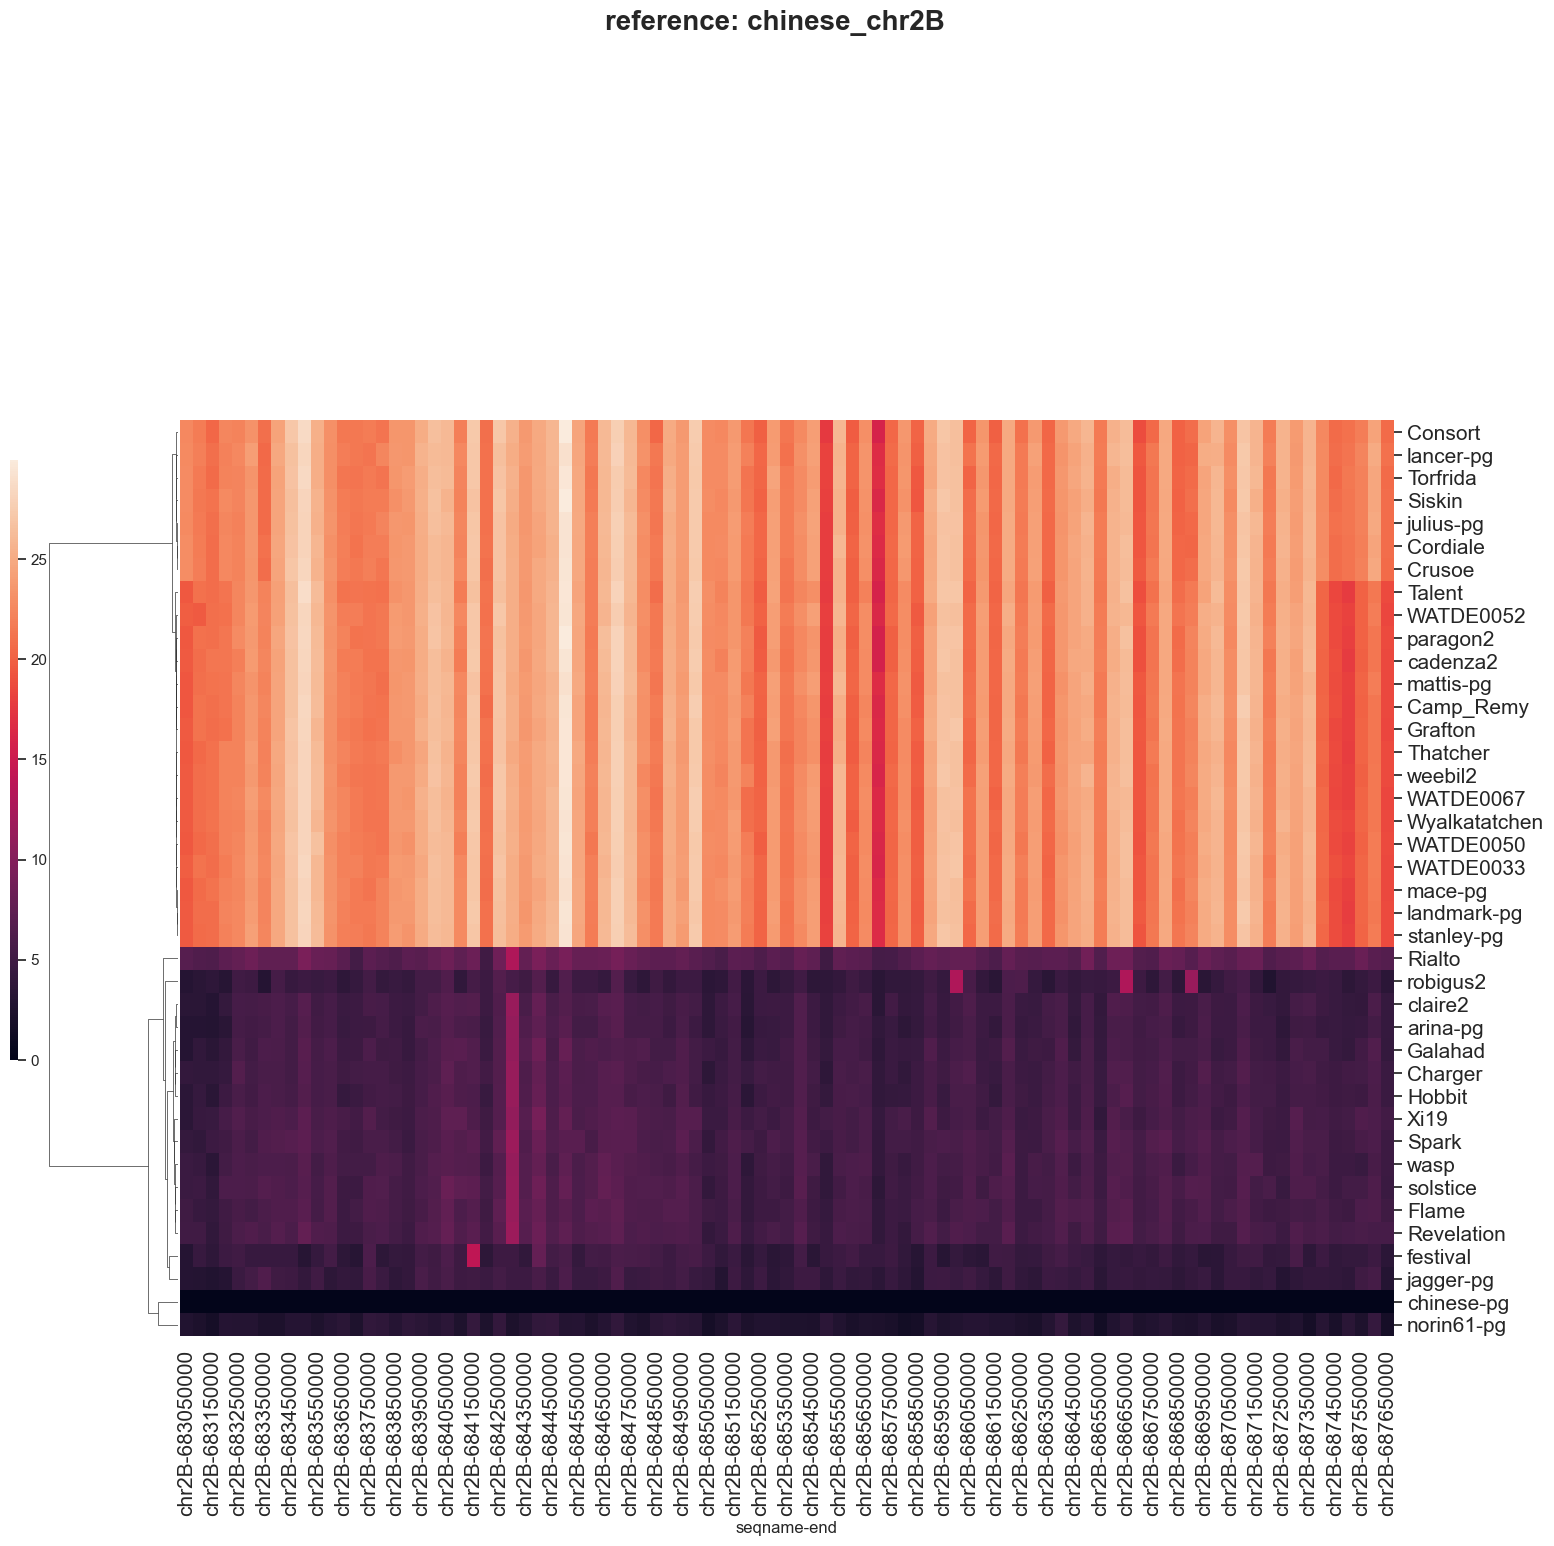

In [22]:
fig_size=(15,15)
down_region=683034442 
up_region=687635975 
df_t = transpose_df(extract_region(filtered_file, chromosome, down_region, up_region, function))
plot_culstermap_col(df_t, fig_size).fig.suptitle(f'reference: {reference}_{chromosome}', fontsize=20, weight="bold", x=0.5, y=1)
# plt.savefig(f'{chromosome}_{reference}_clustermap.pdf', bbox_inches='tight')

In [26]:
synteny_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/09_gene_synteny'
data_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/0_data'

In [27]:
reference_codes = {\
'ari': 'Arina',
'jag':'Jagger',
'sta':'Stanley',
'jul':'Julius',
'lac':'Lancer',
'ldm':'Landmark',
'mac':'Mace',
'nor':'Norin61',
'sym':'Mattis',
'chi':'CS',
'tsp':'Spelt',
'ash':'Ashsyn'}

In [29]:

def target_genes(pangenome_gene_file, gene, reference_codes):
    
    synteny_genes = pd.read_csv(pangenome_gene_file, delimiter='\t')
    synteny_genes_ = synteny_genes['chr'].str.split('__', expand=True)[1]
    synteny_genes['ref'] = synteny_genes_.map(reference_codes)
    synteny_genes['chr'] = synteny_genes['chr'].str.split('_', expand=True)[0]
    target_genes_ = synteny_genes[(synteny_genes['srcmodel'].str.contains(gene))]
    return target_genes_

In [93]:
gene_down = 'TraesCS2B02G486000'
down_matched_gene = target_genes(synteny_path+'/pangenome_gene_synteny.tsv', gene_down, reference_codes)
down_matched_gene

,chr,start,end,ID,srcmodel,ref
26758,chr2B,692305496,692310127,TraesARI2B01G526900,TraesCS2B02G486000.1,Arina
147630,chr2B,683067976,683072607,TraesJAG2B01G522700,TraesCS2B02G486000.1,Jagger
266939,chr2B,686918176,686922825,TraesSTA2B01G531400,TraesCS2B02G486000.1,Stanley
386465,chr2B,679412991,679417654,TraesJUL2B01G522500,TraesCS2B02G486000.1,Julius
505140,chr2B,571789343,571794006,TraesLAC2B01G495900,TraesCS2B02G486000.1,Lancer
625568,chr2B,681306054,681310703,TraesLDM2B01G518200,TraesCS2B02G486000.1,Landmark
744461,chr2B,676059339,676063988,TraesMAC2B01G527200,TraesCS2B02G486000.1,Mace
864678,chr2B,685891318,685895949,TraesNOR2B01G529800,TraesCS2B02G486000.1,Norin61
982952,chr2B,683922586,683927235,TraesSYM2B01G522200,TraesCS2B02G486000.1,Mattis
1104648,chr2B,683035392,683040011,TraesCHI2B01G537400,TraesCS2B02G486000,CS


In [94]:
gene_up = 'TraesCS2B02G490200'
up_matched_gene = target_genes(synteny_path+'/pangenome_gene_synteny.tsv', gene_up, reference_codes)
up_matched_gene

,chr,start,end,ID,srcmodel,ref
26811,chr2B,696903621,696905030,TraesARI2B01G532200,TraesCS2B02G490200.1,Arina
147680,chr2B,687696035,687697444,TraesJAG2B01G527700,TraesCS2B02G490200.1,Jagger
266977,chr2B,690175160,690176569,TraesSTA2B01G535200,TraesCS2B02G490200.1,Stanley
386498,chr2B,681664058,681665467,TraesJUL2B01G525800,TraesCS2B02G490200.1,Julius
505171,chr2B,574060851,574062260,TraesLAC2B01G499000,TraesCS2B02G490200.1,Lancer
625605,chr2B,684548664,684550073,TraesLDM2B01G521900,TraesCS2B02G490200.1,Landmark
744499,chr2B,679274332,679275741,TraesMAC2B01G531000,TraesCS2B02G490200.1,Mace
864723,chr2B,690456492,690457901,TraesNOR2B01G534300,TraesCS2B02G490200.1,Norin61
982992,chr2B,687045978,687047387,TraesSYM2B01G526200,TraesCS2B02G490200.1,Mattis
1104696,chr2B,687634061,687635470,TraesCHI2B01G542200,TraesCS2B02G490200,CS


In [33]:
def drop_references(df, list_of_ref):
    for ref_i in list_of_ref:
        i = df[(df.ref == ref_i)].index
        df = df.drop(i)
    return df

In [103]:
window = 50000
# buffer = 600000

function = np.sqrt
power_n = 0.43

if function is None:
    function_name = "None"
else:
    function_name = function.__name__

# remove references from the analysis
list_of_ref = ['Ashsyn','CS']    
down_matched_gene = drop_references(down_matched_gene, list_of_ref)
# up_matched_gene = drop_references(up_matched_gene, list_of_ref)

references = down_matched_gene['ref'].to_list()

# drop query_samples
list_of_query = ['WATDE0039', 'Santiago-pr','Claire-skm','Mattis']

In [158]:
def get_target_region(by_windowd_db, chromosome, down_region, up_region, function=None, power_n=2):
    
    if function is not None:
        function_name = function.__name__
    function_name = "None"
    
    in_db = by_windowd_db
    target_region_df = in_db[\
                             (in_db['end'] >= down_region) & \
                             (in_db['end'] <= up_region) & \
                             (in_db['seqname'].str.contains(chromosome))\
                            ]
    header = target_region_df[['seqname','end']]
    df_values = target_region_df.iloc[:, 2:]
    
    if function_name == 'power':
        power_n = power_n        
        np_values = function(df_values, power_n)
        final_df = pd.concat([header, np_values], axis=1)
    
    elif function is not None:
        np_values = function(df_values).replace(-np.inf, 0)
        final_df = pd.concat([header, np_values], axis=1)
    else:
        final_df = target_region_df
        
    return final_df

In [119]:
references=["arinalrfor",
"chinese",
"jagger",
"julius",
"lancer",
"landmark",
"mace",
"norin61",
# "spelta",
"stanley",
"sy_mattis"]

In [149]:
data_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/0_IBSpy_data'
# '/Users/quirozc/Documents/PhD_2020/16_watseq/0_IBSpy_data'

In [150]:
def map_substring(s, dict_map):
    for key in dict_map.keys():
        if key in s:
            return dict_map[key]
#         return s

names = {\
        'Jagger':'jagger',
        'Arina':'arinalrfor',
        'Julius':'julius',
        'Lancer':'lancer',
        'Landmark':'landmark',
        'Mace':'mace',
        'Mattis':'sy_mattis',
        'Norin61':'norin61',
        'Spelt':'spelta',
        'Stanley':'stanley',
        'CS':'chinese'
        }

In [161]:
new_col = down_matched_gene['ref'].apply(lambda x: map_substring(x, names))
down_matched_gene['ref'] = new_col
# down_matched_gene.insert(loc=2, column='new_col', value=new_col)
down_matched_gene

In [96]:
new_col = up_matched_gene['ref'].apply(lambda x: map_substring(x, names))
up_matched_gene['ref'] = new_col
up_matched_gene

,chr,start,end,ID,srcmodel,ref
26811,chr2B,696903621,696905030,TraesARI2B01G532200,TraesCS2B02G490200.1,arinalrfor
147680,chr2B,687696035,687697444,TraesJAG2B01G527700,TraesCS2B02G490200.1,jagger
266977,chr2B,690175160,690176569,TraesSTA2B01G535200,TraesCS2B02G490200.1,stanley
386498,chr2B,681664058,681665467,TraesJUL2B01G525800,TraesCS2B02G490200.1,julius
505171,chr2B,574060851,574062260,TraesLAC2B01G499000,TraesCS2B02G490200.1,lancer
625605,chr2B,684548664,684550073,TraesLDM2B01G521900,TraesCS2B02G490200.1,landmark
744499,chr2B,679274332,679275741,TraesMAC2B01G531000,TraesCS2B02G490200.1,mace
864723,chr2B,690456492,690457901,TraesNOR2B01G534300,TraesCS2B02G490200.1,norin61
982992,chr2B,687045978,687047387,TraesSYM2B01G526200,TraesCS2B02G490200.1,sy_mattis
1104696,chr2B,687634061,687635470,TraesCHI2B01G542200,TraesCS2B02G490200,chinese


In [142]:
references=[
"chinese",
"arinalrfor",
"jagger",
"julius",
"lancer",
"landmark",
"mace",
"norin61",
# "spelta",
"stanley",
"sy_mattis",
]

In [160]:
my_list = pd.read_csv('yr7_genotypes.tsv')['genotype'].tolist()
# my_list

In [159]:
dfs = []
my_list = pd.read_csv('yr7_genotypes.tsv')['genotype'].tolist()
for reference in references:
    down_gene_position = int(down_matched_gene[down_matched_gene['ref'] == reference]['start'].values)
    down_chromosome = down_matched_gene[down_matched_gene['ref'] == reference]['chr'].values[0]
    down_region = down_gene_position
    
    up_gene_position = int(up_matched_gene[up_matched_gene['ref'] == reference]['end'].values)
    up_chromosome = up_matched_gene[up_matched_gene['ref'] == reference]['chr'].values[0]
    up_region = up_gene_position

    file_db = pd.read_csv(f'{data_path}/{reference}_combined_queries_{window}w.tsv.gz', delimiter='\t', usecols=my_list)
#     print(file_db)
#     filtered_file = select_genotypes(file_db, my_list)


    get_target_region_ = get_target_region(file_db, down_chromosome, down_region, up_region, function, power_n)
    dfs.append(get_target_region_)
dfs_concat = pd.concat(dfs, axis=0)
dfs_concat

,seqname,end,arina-pg,chinese-pg,jagger-pg,julius-pg,lancer-pg,landmark-pg,mace-pg,mattis-pg,...,Flame,Crusoe,Camp_Remy,wasp,Consort,Rialto,festival,Talent,WATDE0033,solstice
64867,chr2B,683050000,3.000000,0.000000,3.000000,22.649503,22.627417,19.672316,19.467922,19.364917,...,5.000000,22.869193,19.442222,4.582576,22.583180,6.782330,3.000000,19.493589,19.824228,4.582576
64868,chr2B,683100000,3.000000,0.000000,2.828427,21.563859,21.931712,20.736441,20.663978,20.904545,...,4.358899,21.817424,21.095023,4.358899,21.679483,6.324555,4.358899,21.000000,21.189620,4.690416
64869,chr2B,683150000,2.828427,0.000000,2.645751,20.880613,20.904545,20.808652,21.166010,21.189620,...,4.123106,20.808652,20.856654,3.464102,20.396078,6.164414,3.741657,20.736441,20.808652,3.872983
64870,chr2B,683200000,3.316625,0.000000,3.000000,22.449944,22.068076,22.315914,22.090722,21.236761,...,5.099020,22.583180,21.213203,5.385165,22.449944,7.211103,4.690416,21.236761,21.702534,6.082763
64871,chr2B,683250000,5.477226,0.000000,4.582576,22.135944,22.516660,22.516660,22.427661,22.472205,...,5.656854,22.181073,22.226111,6.082763,22.181073,7.681146,5.099020,22.427661,22.494444,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65062,chr2B_WhSYM,686800000,19.798990,19.697716,19.824228,21.817424,22.022716,2.828427,2.645751,0.000000,...,19.442222,21.794495,3.464102,19.390719,21.702534,19.672316,19.646883,3.464102,4.582576,19.570386
65063,chr2B_WhSYM,686850000,19.646883,19.544820,19.621417,21.748563,21.771541,2.000000,2.236068,0.000000,...,19.773720,21.447611,3.162278,19.748418,21.587033,19.899749,19.672316,3.464102,3.464102,19.723083
65064,chr2B_WhSYM,686900000,17.464249,17.720045,17.549929,19.798990,19.672316,1.000000,1.414214,0.000000,...,17.549929,19.874607,2.000000,17.720045,19.824228,17.776389,17.464249,2.449490,2.449490,17.663522
65065,chr2B_WhSYM,686950000,20.542639,20.297783,20.518285,22.978251,23.409400,1.732051,1.414214,0.000000,...,20.639767,22.934690,3.162278,20.445048,22.891046,21.023796,20.493902,2.828427,3.605551,20.566964


Text(0.5, 1, 'reference: sy_mattis_chr2B')

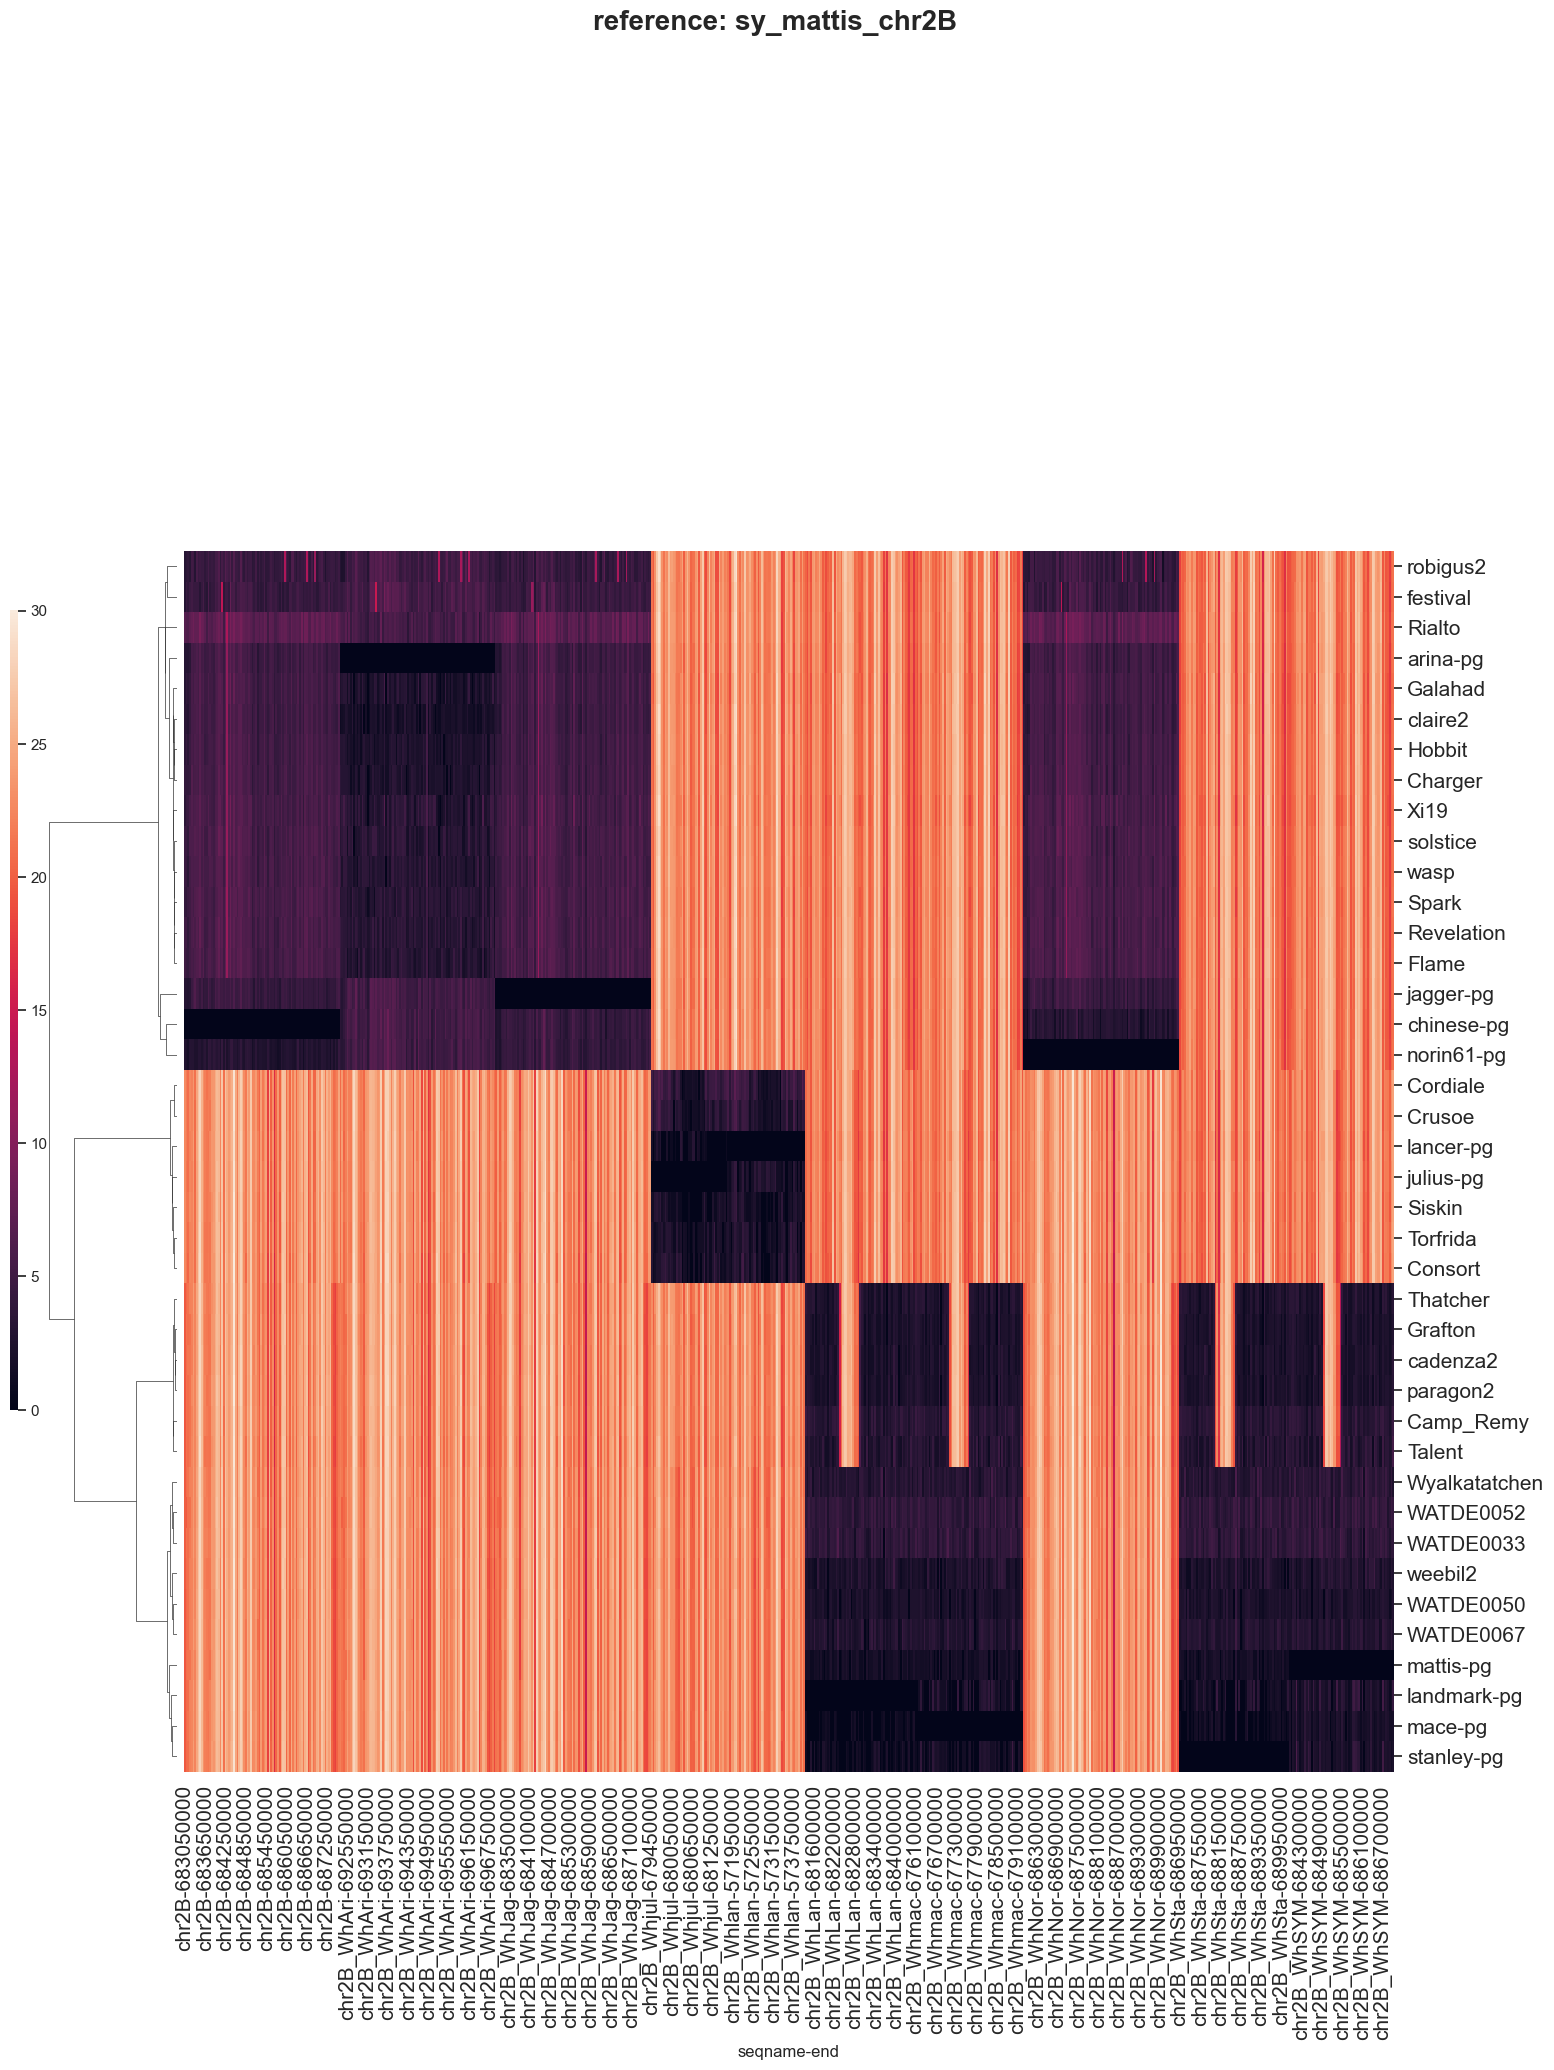

In [162]:
fig_size=(15,20)
# down_region=683034442 
# up_region=687635975 
df_t = transpose_df(dfs_concat)
plot_culstermap_col(df_t, fig_size).fig.suptitle(f'reference: {reference}_{chromosome}', fontsize=20, weight="bold", x=0.5, y=1)
# plt.savefig(f'{chromosome}_{reference}_clustermap.pdf', bbox_inches='tight')

In [107]:
file_db

,seqname,start,end,arina-10x_nuq,arina-pg,cadenza-10.4x_nuq,cadenza-15x_nuq,chinese-10x_nuq,chinese-pg,claire-10x_nuq,...,WATDE0086,WATDE0105,WATDE0165,WATDE0620,WATDE0902,WATDE0246,WATDE0667,WATDE0613,WATDE0924,WATDE0627
0,chr1A_WhAri,1,50000,0,0,426,427,426,429,385,...,437,429,426,424,383,458,462,423,420,425
1,chr1A_WhAri,50001,100000,1,0,427,424,432,424,427,...,416,433,435,438,409,440,431,431,418,426
2,chr1A_WhAri,100001,150000,0,0,571,568,573,582,553,...,575,581,569,565,577,569,562,571,576,585
3,chr1A_WhAri,150001,200000,1,0,541,539,522,521,530,...,535,551,536,522,553,530,540,544,540,542
4,chr1A_WhAri,200001,250000,2,0,189,191,157,178,200,...,215,224,212,212,231,207,228,213,247,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293188,chrUn_WhAri,464450001,464500000,5,0,77,69,44,66,43,...,55,77,74,35,30,70,73,62,100,69
293189,chrUn_WhAri,464500001,464550000,0,0,62,52,58,96,27,...,54,89,56,67,60,48,76,84,43,112
293190,chrUn_WhAri,464550001,464600000,1,0,91,83,44,80,12,...,100,71,77,17,23,81,89,106,70,46
293191,chrUn_WhAri,464600001,464650000,0,0,72,66,96,122,77,...,63,76,46,47,65,63,55,87,80,81


In [ ]:
my_list = pd.read_csv('yr7_genotypes.tsv')['genotype'].tolist()
filtered_file = select_genotypes(in_file, my_list)
filtered_file

In [105]:
dfs_concat

,seqname,window,Timopheevii3708,Alba,Timopheevii22438,Spelt-10x,Ponticumg39-10x,Timopheevi10827-10x,Ritzlhoferneu,Renan-10x,...,WATDE0062,WATDE0064,WATDE0067,WATDE0068,WATDE0080,WATDE0087,WATDE0091,WATDE0109,WATDE0288,Wyalkatatchen
32679,chr2B_WhAri,692400000,29.478806,5.291503,27.640550,32.787193,37.027017,29.086079,4.472136,30.248967,...,32.863353,32.388269,29.546573,32.511536,32.832910,7.549834,30.854497,6.855655,7.280110,29.563491
32680,chr2B_WhAri,692500000,34.394767,4.690416,20.736441,32.480764,37.483330,34.336569,6.633250,32.619013,...,32.588341,31.780497,32.634338,31.527766,32.526912,9.000000,32.664966,7.745967,10.677078,32.419130
32681,chr2B_WhAri,692600000,32.031235,3.872983,20.074860,31.953091,37.696154,31.749016,6.000000,31.591138,...,31.906112,31.654384,32.572995,31.701735,31.906112,7.937254,31.368774,8.124038,10.344080,31.968735
32682,chr2B_WhAri,692700000,38.013156,5.099020,22.671568,38.768544,36.878178,38.026307,7.416198,38.065733,...,38.314488,38.353618,38.574603,38.470768,38.910153,8.944272,38.052595,7.937254,11.489125,38.366652
32683,chr2B_WhAri,692800000,35.986108,4.898979,20.469489,36.414283,38.935845,35.930488,7.549834,36.755952,...,36.180105,36.000000,36.619667,36.290495,36.400549,9.539392,36.728735,9.591663,13.564660,36.455452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32473,chr2B_Whspe,680200000,34.655447,4.242641,34.073450,1.000000,35.972211,34.641016,32.787193,32.710854,...,33.882149,3.872983,33.763886,32.680269,33.689761,5.744563,34.088121,33.241540,32.634338,32.787193
32474,chr2B_Whspe,680300000,31.160873,5.744563,30.740852,1.732051,33.406586,31.208973,26.324893,9.746794,...,30.838288,4.795832,30.675723,9.899495,30.886890,6.633250,30.626786,31.112698,10.148892,29.849623
32475,chr2B_Whspe,680400000,36.249138,4.358899,35.888717,3.000000,34.146742,36.290495,29.410882,4.123106,...,35.763109,4.242641,35.482390,5.830952,35.818989,5.196152,35.679126,35.749126,4.358899,34.481879
32476,chr2B_Whspe,680500000,30.610456,6.000000,30.182777,3.872983,34.871192,30.659419,27.166155,7.348469,...,30.446675,5.744563,30.854497,6.403124,30.951575,7.615773,30.854497,31.048349,5.830952,30.561414
